<a href="https://colab.research.google.com/github/divyam123-EECS-Physics/NetLoadForecastingScripts/blob/main/or_submission_july1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
!pip install solarforecastarbiter
!pip install TimezoneFinder
# # # !pip instal
!pip install -q gluonts
!pip install lightning
!pip install "gluonts[torch]"
!pip install "gluonts[mxnet]"
# !pip uninstall mxnet --yes
# !pip install mxnet-cu112
import numpy as np
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score
import solarforecastarbiter.reference_forecasts
from solarforecastarbiter.reference_forecasts.persistence import persistence_probabilistic_timeofday

from gluonts.mx.distribution.gaussian import GaussianOutput
from gluonts.mx.distribution.student_t import StudentTOutput
from gluonts.mx import Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.mx.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator
from gluonts.mx.model.tft import TemporalFusionTransformerEstimator
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.model.deepstate import DeepStateEstimator
from gluonts.mx.model.seq2seq import MQCNNEstimator
from solarforecastarbiter.io import api


# from gluonts.mx.model.deep_npts import DeepNPTSEstimator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.6 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [2]:

import numpy as np
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score
import solarforecastarbiter.reference_forecasts
from solarforecastarbiter.reference_forecasts.persistence import persistence_probabilistic_timeofday

from gluonts.mx.distribution.gaussian import GaussianOutput
from gluonts.mx.distribution.student_t import StudentTOutput
from gluonts.mx import Trainer
from gluonts.evaluation import make_evaluation_predictions
from gluonts.mx.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.dataset.common import ListDataset
from gluonts.evaluation import Evaluator
from gluonts.mx.model.tft import TemporalFusionTransformerEstimator
from gluonts.mx.model.deepar import DeepAREstimator
from gluonts.mx.model.deepstate import DeepStateEstimator
from gluonts.mx.model.seq2seq import MQCNNEstimator
from solarforecastarbiter.io import api

In [3]:
def TimeZoning(lon, lati, df):
    tf = TimezoneFinder(in_memory=True)
    local_time_zone = tf.timezone_at(lng=lon, lat=lati)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['timestamp'] = df['timestamp'].dt.tz_localize(tz = 'UTC').dt.tz_convert(tz=local_time_zone)
    return df
#Gives crps_scores
#The lower the score, the better
def scorer(df, predictor, context_days, prediction_days,sum_bool):
        crps_score = []
        df3 = df
        times = []
        for month in range(5,9):
            if month in set([1,3,5,7,8,10]):
                days = 31
            elif month in set([4,6,9,11]):
                days = 30
            else:
                days = 28
            for day in range(1,days + 1):
                    print("day",month, day)
                    target_time = "2022-{:02d}-{:02d} 00:00:00".format(month,day)
                    # target_time = '2022-06-01 00:00:00'
                    test = df3[df3['timestamp'] >= pd.Timestamp(target_time)][:24*(context_days + prediction_days)]
                    times.append(pd.Timestamp(target_time))
                    data_list = [{"start": target_time,
                                  "target": test['value'].values,
                                  'feat_dynamic_real':test.drop(columns = ['value', 'timestamp']).T,
                                  }]
                    train_ds_test  = ListDataset(data_iter=data_list,freq='1H')


                    forecast_it, ts_it = make_evaluation_predictions(
                        dataset=train_ds_test,  # dataset
                        predictor=predictor,  # predictor
                        num_samples=500,  # number of sample paths we want for evaluation
                    )

                    forecasts = list(forecast_it)
                    tss = list(ts_it)

                    fx_prob = np.zeros((24,11))
                    constant_values = np.array([x/10 for x in range(0,11)])
                    for i in range(11):
                        fx_prob[:, i] = constant_values[i]
                    preds = np.zeros((24,11))
                    for i in range(11):
                        preds[:,i] = forecasts[0].quantile(i/10)[-24:]
                    score = continuous_ranked_probability_score(obs = test['value'][-24:].values, fx = preds, fx_prob = fx_prob)

                    crps_score.append(score)
        if (sum_bool == True):
            return sum(crps_score)

        return crps_score,times
#Gives us the the output of putting a test set (test_df) through the model
#Gives us a visualization of the model
def predictor_fn(model, test_df, cut_off_date, context_days, prediction_days):
    time_of_choice = pd.Timestamp(cut_off_date)
    target_time = time_of_choice - pd.Timedelta(unit = 'H', value = 24 * context_days)

    test = test_df[test_df['timestamp'] >= pd.Timestamp(target_time)][:24 * (context_days + prediction_days) + 2]

    data_list = [{"start": target_time,
                  "target": test['value'].values,
                  'feat_dynamic_real':test.drop(columns = ['value', 'timestamp']).T}]
    train_ds_test  = ListDataset(data_iter=data_list,freq='1H')
    prediction_intervals = [i/10 for i in range(11)]

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=train_ds_test,  # dataset
        predictor=model,  # predictor
        num_samples=1000,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)

    fig, ax = plt.subplots(1, 1, figsize=(18, 7))
    for forecast in forecasts:
        forecast.plot(intervals=prediction_intervals, color='g')
    for ts in tss:
        ts.plot(ax=ax,label = 'ts')
    return forecast, tss
from solarforecastarbiter.io import api
def upload_function(data_df, state = 'hi'):
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")
    if state == 'hi':

        hawaii_forecast_ids = [
           ["60534840-0044-11ee-8096-22bbbfba48a8", "p0"],
           ["60551d2e-0044-11ee-aea4-22bbbfba48a8", "p10"],
           ["60577a7c-0044-11ee-9d93-22bbbfba48a8", "p20"],
           ["6059b4ae-0044-11ee-b9f7-22bbbfba48a8", "p30"],
           ["605c7e09-0044-11ee-88c5-22bbbfba48a8", "p40"],
           ["605f5aad-0044-11ee-a68f-22bbbfba48a8", "p50"],
           ["6061a141-0044-11ee-b645-22bbbfba48a8", "p60"],
           ["6063f5d3-0044-11ee-a725-22bbbfba48a8", "p70"],
           ["606656a8-0044-11ee-aca6-22bbbfba48a8", "p80"],
           ["6069aa58-0044-11ee-b4a8-22bbbfba48a8", "p90"],
           ["606c387a-0044-11ee-92ea-22bbbfba48a8", "p100"],
        ]
        for uuid, col in hawaii_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'tx':
        tx_forecast_ids = [
           ["51936f7f-0044-11ee-8006-22bbbfba48a8", "p0"],
           ["5195a4a9-0044-11ee-9abe-22bbbfba48a8", "p10"],
           ["5199b969-0044-11ee-8c5b-22bbbfba48a8", "p20"],
           ["519be6af-0044-11ee-aa1b-22bbbfba48a8", "p30"],
           ["519e4691-0044-11ee-ace3-22bbbfba48a8", "p40"],
           ["51a07836-0044-11ee-b70a-22bbbfba48a8", "p50"],
           ["51a2b229-0044-11ee-9369-22bbbfba48a8", "p60"],
           ["51a54811-0044-11ee-9b1c-22bbbfba48a8", "p70"],
           ["51a78587-0044-11ee-ac5f-22bbbfba48a8", "p80"],
           ["51a96889-0044-11ee-95de-22bbbfba48a8", "p90"],
           ["51ac716f-0044-11ee-96a0-22bbbfba48a8", "p100"],
        ]
        for uuid, col in tx_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'or':

        or_forecast_ids = [
           ["58ea38ee-0044-11ee-abf9-aa678857fb1c", "p0"],
           ["58ecd0ac-0044-11ee-96ef-aa678857fb1c", "p10"],
           ["58efa6af-0044-11ee-a87e-aa678857fb1c", "p20"],
           ["58f2856f-0044-11ee-94d6-aa678857fb1c", "p30"],
           ["58f4d11c-0044-11ee-80ca-aa678857fb1c", "p40"],
           ["58f792d8-0044-11ee-869d-aa678857fb1c", "p50"],
           ["58fa355e-0044-11ee-881a-aa678857fb1c", "p60"],
           ["58fc98a1-0044-11ee-b2cb-aa678857fb1c", "p70"],
           ["58ff236c-0044-11ee-ba4c-aa678857fb1c", "p80"],
           ["5901b51f-0044-11ee-aae2-aa678857fb1c", "p90"],
           ["59045e2b-0044-11ee-8914-aa678857fb1c", "p100"],
        ]
        for uuid, col in or_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'ga':

        ga_forecast_ids = [
           ["493ba331-0044-11ee-936c-aa678857fb1c", "p0"],
           ["493e3bce-0044-11ee-bdf4-aa678857fb1c", "p10"],
           ["4940a921-0044-11ee-8e27-aa678857fb1c", "p20"],
           ["49431d34-0044-11ee-a476-aa678857fb1c", "p30"],
           ["4945f80a-0044-11ee-8674-aa678857fb1c", "p40"],
           ["49489e6d-0044-11ee-8ce3-aa678857fb1c", "p50"],
           ["494b350e-0044-11ee-b5bc-aa678857fb1c", "p60"],
           ["494fe072-0044-11ee-bb2d-aa678857fb1c", "p70"],
           ["4952cab3-0044-11ee-afa5-aa678857fb1c", "p80"],
           ["4955940c-0044-11ee-a0c7-aa678857fb1c", "p90"],
           ["495827d0-0044-11ee-83b0-aa678857fb1c", "p100"],
        ]

        for uuid, col in ga_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            print(upload_df)
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return

In [4]:
from timezonefinder import TimezoneFinder
states = {
    'hi': {
        "lat":21.446911,
        "lon":-158.188736,
        "fresh_data_time":'12',
    },
    'or': {
        "lat":45.114559,
        "lon":-123.204903,
        "fresh_data_time":'12',
    },
    'tx': {
        "lat":29.424122,
        "lon":-98.493629,
        "fresh_data_time":'06',
    },
    'ga': {
        "lat":31.044241,
        "lon":-84.879128,
        "fresh_data_time":'06',
    },

}
tf = TimezoneFinder(in_memory=True)
for state in states:
  local_time_zone = tf.timezone_at(lng = states[state]['lon'], lat = states[state]['lat'])
  states[state]['local_time_zone'] = local_time_zone


tx_lon = -98.493629
tx_lat = 29.424122
ga_lon = -84.879128
ga_lat = 31.044241
or_lon = -123.204903
or_lat = 45.114559
hi_lat = 21.446911
hi_lon = -158.188736

LOADING AND PREPPING DATASETS

In [5]:
import pandas as pd

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
ga_historiacal = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/oregon_historical.csv')



In [ ]:
ga_forecast = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/test_datasets/oregon_2023-06-30_test.csv')




In [ ]:
# ga_forecast.drop(columns = [

#               'Unnamed: 0',


# ], inplace = True)

In [ ]:
# ga_historiacal.drop(columns =
#                     [
#                         'pressure_msl (hPa)',
#                         'surface_pressure (hPa)',
#                         'rain (mm)',
#                         'snowfall (cm)',
#                         'windspeed_10m (km/h)', 'winddirection_10m (°)', 'windgusts_10m (km/h)',
#                         'et0_fao_evapotranspiration (mm)', 'vapor_pressure_deficit (kPa)',

#                     ], inplace = True

#                     )

In [ ]:
ga_forecast.rename(columns = {'time':'timestamp'}, inplace = True)
ga_historiacal.rename(columns = {'time':'timestamp'}, inplace = True)

In [ ]:
ga_forecast

,timestamp,value,quality_flag,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,sunset,sunrise
0,2023-06-01 01:00:00,0.281151,16402.0,8.1,76,4.2,6.1,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
1,2023-06-01 02:00:00,0.280982,16402.0,7.2,77,3.5,5.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
2,2023-06-01 03:00:00,0.291136,16402.0,6.5,78,2.9,4.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
3,2023-06-01 04:00:00,0.302375,16402.0,5.6,80,2.5,3.2,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
4,2023-06-01 05:00:00,0.345335,16402.0,5.0,80,1.9,2.5,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-06-01T20:54,2023-06-01T05:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,NaN,31.6,19,5.1,28.8,0.0,0,0,0,0,373.0,321.0,52.0,832.2,2023-07-03T21:05,2023-07-03T05:29
787,2023-07-03 20:00:00,NaN,NaN,27.9,29,8.2,26.3,0.0,0,0,0,0,192.0,153.0,39.0,723.6,2023-07-03T21:05,2023-07-03T05:29
788,2023-07-03 21:00:00,NaN,NaN,21.7,47,9.9,20.3,0.0,0,0,0,0,41.0,26.0,15.0,369.3,2023-07-03T21:05,2023-07-03T05:29
789,2023-07-03 22:00:00,NaN,NaN,17.5,64,10.6,16.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,2023-07-03T21:05,2023-07-03T05:29


In [ ]:
ga_historiacal['timestamp'] = pd.to_datetime(ga_historiacal['timestamp'])
ga_forecast['timestamp'] = pd.to_datetime(ga_forecast['timestamp'])


In [ ]:
# ga_historiacal.drop(columns='Unnamed: 0', inplace = True)
ga_historiacal.columns

Index(['timestamp', 'value', 'quality_flag', 'temperature_2m',
       'relativehumidity_2m', 'dewpoint_2m', 'apparent_temperature',
       'precipitation', 'cloudcover', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'direct_normal_irradiance', 'sunset', 'sunrise'],
      dtype='object')

In [ ]:
def transformations(df):
  cols = ['temperature_2m (°C)','dewpoint_2m (°C)','apparent_temperature (°C)',
          'precipitation (mm)','shortwave_radiation (W/m²)','direct_radiation (W/m²)',
          'diffuse_radiation (W/m²)', 'direct_normal_irradiance (W/m²)']
  # for col in df.columns:
    # if col in cols:
    #   df[col] = (df[col] - np.mean(df[col])) / np.std(df[col])
    # elif col not in cols and col != 'timestamp' and col != 'value':
    #   df[col] = df[col] / 100

  df['hour'] = (df['timestamp'].dt.hour - 12 )/ 24
  return df

In [ ]:
hist_df = transformations(ga_historiacal)

In [ ]:
for_df = transformations(ga_forecast)

In [ ]:
for_df = for_df[hist_df.columns]

In [ ]:
for_df.drop(columns = ['sunrise','sunset'], inplace = True)
hist_df.drop(columns = ['sunrise','sunset'], inplace = True)

In [ ]:
pd.to_datetime(hist_df['timestamp'])

0       2022-01-01 01:00:00
1       2022-01-01 02:00:00
2       2022-01-01 03:00:00
3       2022-01-01 04:00:00
4       2022-01-01 05:00:00
                ...        
12353   2023-05-30 20:00:00
12354   2023-05-30 21:00:00
12355   2023-05-30 22:00:00
12356   2023-05-30 23:00:00
12357   2023-05-31 00:00:00
Name: timestamp, Length: 12358, dtype: datetime64[ns]

In [ ]:
hist_df

,timestamp,value,quality_flag,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,hour
0,2022-01-01 01:00:00,0.661744,0,-3.2,83,-5.8,-7.5,0.0,34,6,0,94,0.0,0.0,0.0,0.0,-0.458333
1,2022-01-01 02:00:00,0.667333,0,-3.4,82,-6.1,-8.0,0.0,41,17,0,87,0.0,0.0,0.0,0.0,-0.416667
2,2022-01-01 03:00:00,0.683100,0,-3.1,78,-6.4,-7.8,0.0,54,38,0,65,0.0,0.0,0.0,0.0,-0.375000
3,2022-01-01 04:00:00,0.717013,0,-2.9,75,-6.7,-8.0,0.0,47,37,0,46,0.0,0.0,0.0,0.0,-0.333333
4,2022-01-01 05:00:00,0.747671,0,-3.0,74,-6.9,-8.6,0.0,48,41,1,36,0.0,0.0,0.0,0.0,-0.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12353,2023-05-30 20:00:00,0.457141,16386,14.3,47,3.1,10.7,0.0,2,2,0,0,157.0,109.0,48.0,624.3,0.333333
12354,2023-05-30 21:00:00,0.447249,16386,12.5,53,3.1,8.6,0.0,1,1,0,0,24.0,12.0,12.0,219.6,0.375000
12355,2023-05-30 22:00:00,0.377017,16402,11.1,59,3.4,7.2,0.0,2,2,0,0,0.0,0.0,0.0,0.0,0.416667
12356,2023-05-30 23:00:00,0.330182,16402,10.2,64,3.6,6.8,0.0,5,5,0,0,0.0,0.0,0.0,0.0,0.458333


In [ ]:
start = "2022-05-01 00:00:00"
end = "2022-08-15 00:00:00"
train_data_list_sum = [{"start": start,
              "target": hist_df[(hist_df['timestamp'] >= pd.Timestamp(start))&
                          (hist_df['timestamp'] <= pd.Timestamp(end))]['value'].values,
              'feat_dynamic_real':hist_df[(hist_df['timestamp'] >= pd.Timestamp(start))&
                          (hist_df['timestamp'] <= pd.Timestamp(end))].drop(columns = ['value', 'timestamp']).T,
              }]
train_ds_sum  = ListDataset(data_iter=train_data_list_sum,freq='1H')




start = "2022-05-01 00:00:00"
end = "2022-08-15 00:00:00"
train_data_list_complete = [{"start": start,
              "target": hist_df['value'].values,
              'feat_dynamic_real':hist_df.drop(columns = ['value', 'timestamp']).T,
              }]
train_ds_comp  = ListDataset(data_iter=train_data_list_complete,freq='1H')

In [ ]:
test_data_list_complete = [{"start": start,
              "target": for_df['value'].values,
              'feat_dynamic_real':for_df.drop(columns = ['value', 'timestamp']).T,
              }]
test_ds_comp  = ListDataset(data_iter=test_data_list_complete,freq='1H')

In [ ]:
pd.to_datetime('2023-06-13 00:00') + pd.Timedelta(13 * 24,'H')

Timestamp('2023-06-26 00:00:00')

In [ ]:
# context_days_nn = 13
# prediction_days_nn = 13
# context_length = 24 * context_days_nn # train on this number of days
# prediction_length = (24 * prediction_days_nn) # predict these many days, these are removed from the end of the training data

# estimator_nn_comp = MQCNNEstimator(freq='1H',
#                                        context_length=context_length,
#                                        prediction_length=prediction_length,
#                                    use_feat_dynamic_real = True,
#                                       quantiles = [i/10 for i in range(11)],
#                                        trainer=Trainer(epochs=50,
#                                                        learning_rate=1e-3,
#                                                        num_batches_per_epoch=100
#                                                       ))
# predictor_nn_comp = estimator_nn_comp.train(train_ds_comp)




In [ ]:
for_df.columns

Index(['timestamp', 'value', 'quality_flag', 'temperature_2m',
       'relativehumidity_2m', 'dewpoint_2m', 'apparent_temperature',
       'precipitation', 'cloudcover', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'direct_normal_irradiance', 'hour'],
      dtype='object')

In [ ]:
# context_days_nn = 10
# prediction_days_nn = 5
# context_length = 24 * context_days_nn # train on this number of days
# prediction_length = (24 * prediction_days_nn) # predict these many days, these are removed from the end of the training data

# estimator_are_comp = DeepAREstimator(freq='1H',
#                                        context_length=context_length,
#                                        prediction_length=prediction_length,
#                                     num_layers = 3,
#                                     num_cells = 40,
#                                    use_feat_dynamic_real = True,
#                                        trainer=Trainer(epochs=25,
#                                                        learning_rate=1e-3,
#                                                        num_batches_per_epoch=100
#                                                       ))
# predictor_are_comp = estimator_are_comp.train(train_ds_comp)




In [ ]:
from pathlib import Path

# predictor_are_comp.serialize(Path("/content/"))

In [ ]:
context_days_nn = 10
prediction_days_nn = 5
context_length = 24 * context_days_nn # train on this number of days
prediction_length = (24 * prediction_days_nn) + 2# predict these many days, these are removed from the end of the training data

estimator_nn_comp = SimpleFeedForwardEstimator(num_hidden_dimensions=[5],
                                       context_length=context_length,
                                       prediction_length=prediction_length,
                                       distr_output=GaussianOutput(),
                                       trainer=Trainer(epochs=50,
                                                       learning_rate=1e-3,
                                                       num_batches_per_epoch=100
                                                      ))
predictor_nn_comp = estimator_nn_comp.train(train_ds_sum)

100%|██████████| 100/100 [00:01<00:00, 69.20it/s, epoch=50/50, avg_epoch_loss=-1.33]


In [ ]:
for_df

,timestamp,value,quality_flag,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,hour
0,2023-06-01 01:00:00,0.281151,16402.0,8.1,76,4.2,6.1,0.0,0,0,0,0,0.0,0.0,0.0,0.0,-0.458333
1,2023-06-01 02:00:00,0.280982,16402.0,7.2,77,3.5,5.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,-0.416667
2,2023-06-01 03:00:00,0.291136,16402.0,6.5,78,2.9,4.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,-0.375000
3,2023-06-01 04:00:00,0.302375,16402.0,5.6,80,2.5,3.2,0.0,0,0,0,0,0.0,0.0,0.0,0.0,-0.333333
4,2023-06-01 05:00:00,0.345335,16402.0,5.0,80,1.9,2.5,0.0,0,0,0,0,0.0,0.0,0.0,0.0,-0.291667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786,2023-07-03 19:00:00,NaN,NaN,31.6,19,5.1,28.8,0.0,0,0,0,0,373.0,321.0,52.0,832.2,0.291667
787,2023-07-03 20:00:00,NaN,NaN,27.9,29,8.2,26.3,0.0,0,0,0,0,192.0,153.0,39.0,723.6,0.333333
788,2023-07-03 21:00:00,NaN,NaN,21.7,47,9.9,20.3,0.0,0,0,0,0,41.0,26.0,15.0,369.3,0.375000
789,2023-07-03 22:00:00,NaN,NaN,17.5,64,10.6,16.3,0.0,0,0,0,0,0.0,0.0,0.0,0.0,0.416667


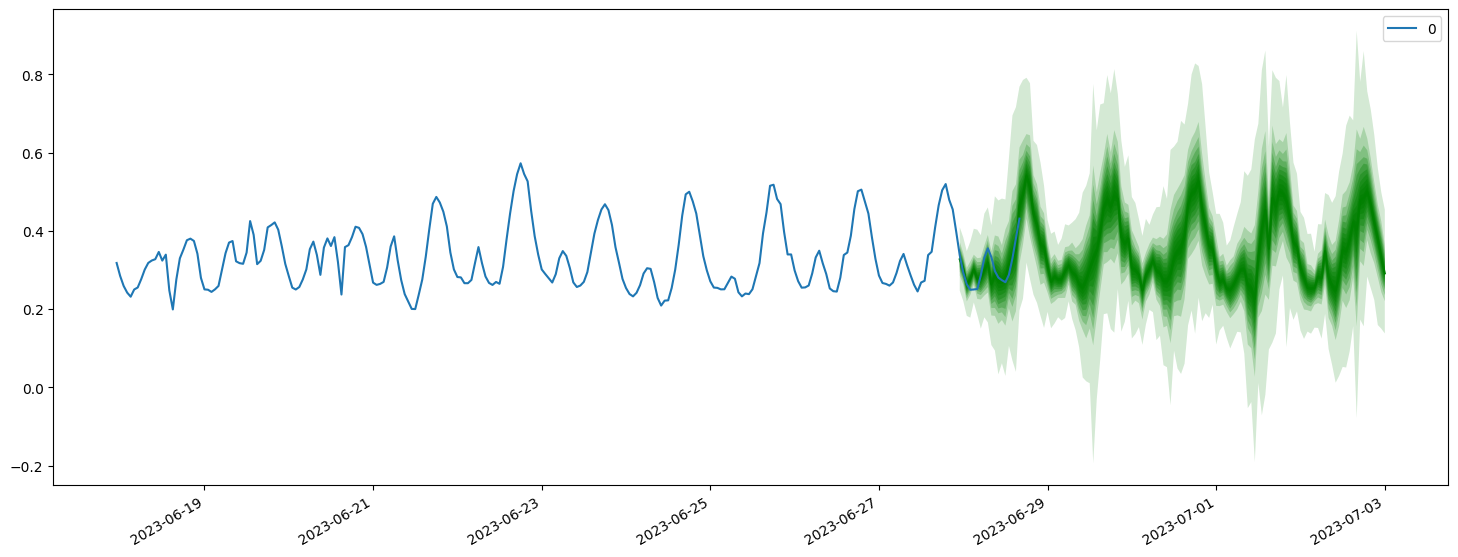

In [ ]:
# forecast_big = predictor_fn(predictor_are_comp, for_df, "2022-07-13 00:00:00", 5, 3)
forecast_big = predictor_fn(predictor_nn_comp, for_df, "2023-06-27 23:00:00", 10, 5)


In [ ]:
import torch
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score,crps_skill_score
from solarforecastarbiter.io import api
def upload_function(data_df, state = 'hi'):
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")
    if state == 'hi':

        hawaii_forecast_ids = [
           ["60534840-0044-11ee-8096-22bbbfba48a8", "p0"],
           ["60551d2e-0044-11ee-aea4-22bbbfba48a8", "p10"],
           ["60577a7c-0044-11ee-9d93-22bbbfba48a8", "p20"],
           ["6059b4ae-0044-11ee-b9f7-22bbbfba48a8", "p30"],
           ["605c7e09-0044-11ee-88c5-22bbbfba48a8", "p40"],
           ["605f5aad-0044-11ee-a68f-22bbbfba48a8", "p50"],
           ["6061a141-0044-11ee-b645-22bbbfba48a8", "p60"],
           ["6063f5d3-0044-11ee-a725-22bbbfba48a8", "p70"],
           ["606656a8-0044-11ee-aca6-22bbbfba48a8", "p80"],
           ["6069aa58-0044-11ee-b4a8-22bbbfba48a8", "p90"],
           ["606c387a-0044-11ee-92ea-22bbbfba48a8", "p100"],
        ]
        for uuid, col in hawaii_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'tx':
        tx_forecast_ids = [
           ["51936f7f-0044-11ee-8006-22bbbfba48a8", "p0"],
           ["5195a4a9-0044-11ee-9abe-22bbbfba48a8", "p10"],
           ["5199b969-0044-11ee-8c5b-22bbbfba48a8", "p20"],
           ["519be6af-0044-11ee-aa1b-22bbbfba48a8", "p30"],
           ["519e4691-0044-11ee-ace3-22bbbfba48a8", "p40"],
           ["51a07836-0044-11ee-b70a-22bbbfba48a8", "p50"],
           ["51a2b229-0044-11ee-9369-22bbbfba48a8", "p60"],
           ["51a54811-0044-11ee-9b1c-22bbbfba48a8", "p70"],
           ["51a78587-0044-11ee-ac5f-22bbbfba48a8", "p80"],
           ["51a96889-0044-11ee-95de-22bbbfba48a8", "p90"],
           ["51ac716f-0044-11ee-96a0-22bbbfba48a8", "p100"],
        ]
        for uuid, col in tx_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'or':

        or_forecast_ids = [
           ["58ea38ee-0044-11ee-abf9-aa678857fb1c", "p0"],
           ["58ecd0ac-0044-11ee-96ef-aa678857fb1c", "p10"],
           ["58efa6af-0044-11ee-a87e-aa678857fb1c", "p20"],
           ["58f2856f-0044-11ee-94d6-aa678857fb1c", "p30"],
           ["58f4d11c-0044-11ee-80ca-aa678857fb1c", "p40"],
           ["58f792d8-0044-11ee-869d-aa678857fb1c", "p50"],
           ["58fa355e-0044-11ee-881a-aa678857fb1c", "p60"],
           ["58fc98a1-0044-11ee-b2cb-aa678857fb1c", "p70"],
           ["58ff236c-0044-11ee-ba4c-aa678857fb1c", "p80"],
           ["5901b51f-0044-11ee-aae2-aa678857fb1c", "p90"],
           ["59045e2b-0044-11ee-8914-aa678857fb1c", "p100"],
        ]
        for uuid, col in or_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'ga':

        ga_forecast_ids = [
           ["493ba331-0044-11ee-936c-aa678857fb1c", "p0"],
           ["493e3bce-0044-11ee-bdf4-aa678857fb1c", "p10"],
           ["4940a921-0044-11ee-8e27-aa678857fb1c", "p20"],
           ["49431d34-0044-11ee-a476-aa678857fb1c", "p30"],
           ["4945f80a-0044-11ee-8674-aa678857fb1c", "p40"],
           ["49489e6d-0044-11ee-8ce3-aa678857fb1c", "p50"],
           ["494b350e-0044-11ee-b5bc-aa678857fb1c", "p60"],
           ["494fe072-0044-11ee-bb2d-aa678857fb1c", "p70"],
           ["4952cab3-0044-11ee-afa5-aa678857fb1c", "p80"],
           ["4955940c-0044-11ee-a0c7-aa678857fb1c", "p90"],
           ["495827d0-0044-11ee-83b0-aa678857fb1c", "p100"],
        ]

        for uuid, col in ga_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            print(upload_df)
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return


def get_reference_forecasts(location, start_date, end_date):
    # Access related parameters for Net Load Forecast Site
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    start_datetime = start_date + ' 01:00:00'
    end_datetime = end_date + ' 00:00:00'
    #Reference Probablistic Persistance Ensemble Forecast
    locations = {'4a3de81c-0043-11ee-a474-aa678857fb1c':['Pacific/Honolulu','Waianae_Hawaii'],
                '49cdf54e-0043-11ee-a581-aa678857fb1c':['America/Los_Angeles','Amity_OR'],
                '496055a3-0043-11ee-ada4-aa678857fb1c':['America/Chicago','SanAntonio_TX'],
                '3b6b45e3-0043-11ee-bfe9-aa678857fb1c':['America/New_York','Donalsonville_GA']}
    locations_uuids = {
        'hi':'4a3de81c-0043-11ee-a474-aa678857fb1c',
        'or':'49cdf54e-0043-11ee-a581-aa678857fb1c',
        'tx':'496055a3-0043-11ee-ada4-aa678857fb1c',
        'ga':'3b6b45e3-0043-11ee-bfe9-aa678857fb1c'
    }
    # for uuid in locations.keys():
    uuid = locations_uuids[location]
    tmz=locations[uuid][0]

    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")

    session.get_probabilistic_forecast(uuid)

    start = pd.Timestamp(start_datetime).tz_localize(tmz)
    end = pd.Timestamp(end_datetime).tz_localize(tmz)
    fdf = session.get_probabilistic_forecast_values(uuid, start, end)
    fdf = fdf.reset_index('timestamp')
    fdf = fdf.rename(columns = {'timestamp':'time'})
    fdf.time = fdf.time.dt.tz_convert(tmz)
    fdf.time = fdf.time.dt.tz_localize(None)
    return fdf

def crps_and_crpss_scores(obs, predictions, start_date, end_date, location):

    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
    reference_df = get_reference_forecasts(location, start_date, end_date)
    reference_val = reference_df.drop(columns = 'time').values

    crps = continuous_ranked_probability_score(obs, predictions, fx_prob)
    crpss = crps_skill_score(obs, predictions,  fx_prob, reference_val, fx_prob)

    return crps, crpss, reference_df


0.07751554494941958 -1.5408310989580896
0.054679996881871674 -0.2772979606153787
0.041321564996032976 -0.5599602340738761
0.05901290126994377 -0.9153542389006333
0.04029713978913302 -0.6670002597705698
0.042087074907224936 -0.36758316122619594
0.023953088613343426 0.09041297422784245
0.036985164654906845 -0.30600459100232436
0.04244800896548744 -0.3628614776314665
0.03861785503977444 -1.3556986950613323
0.04891119944882424 -1.5225382217933747


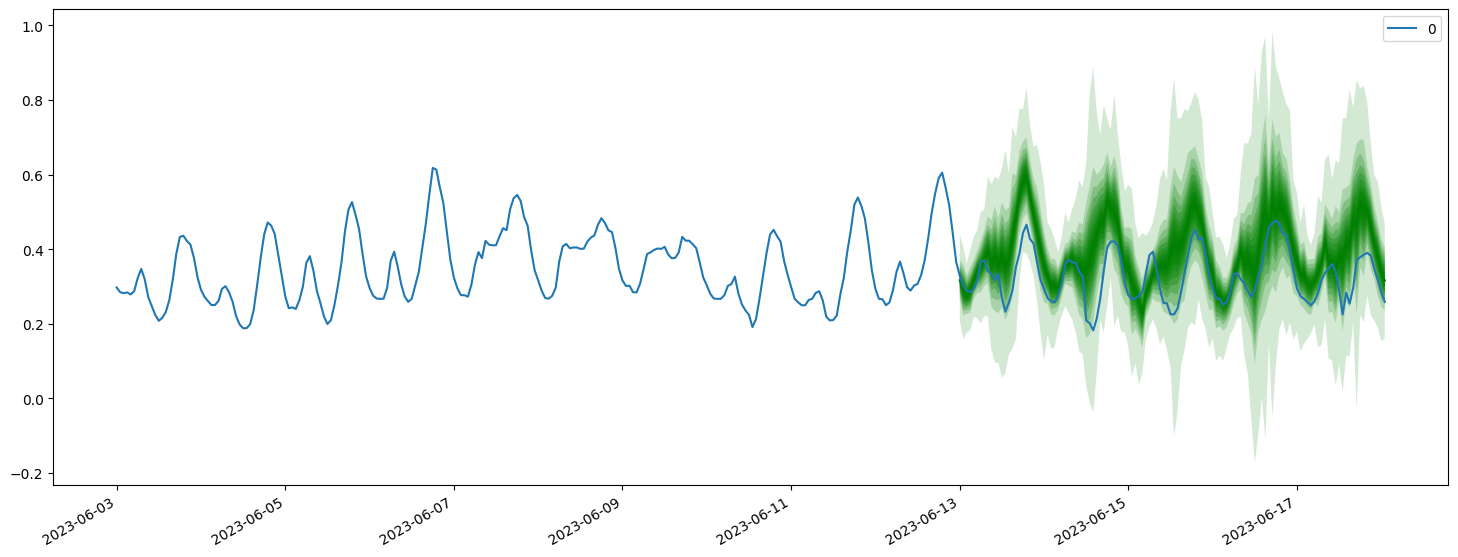

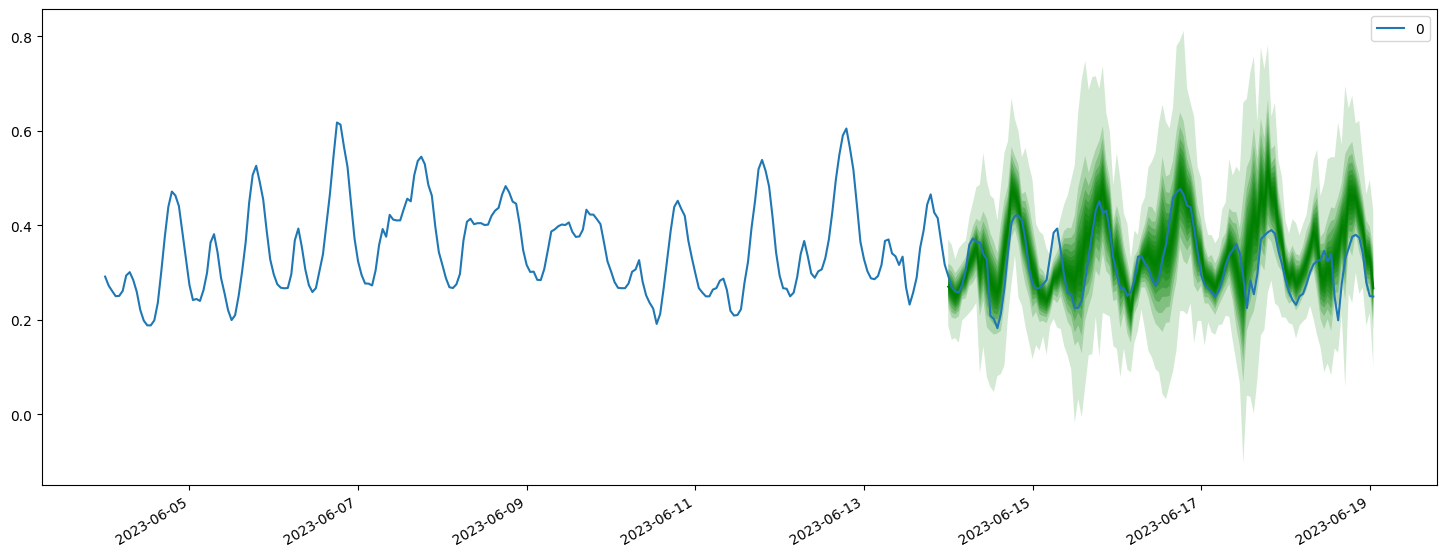

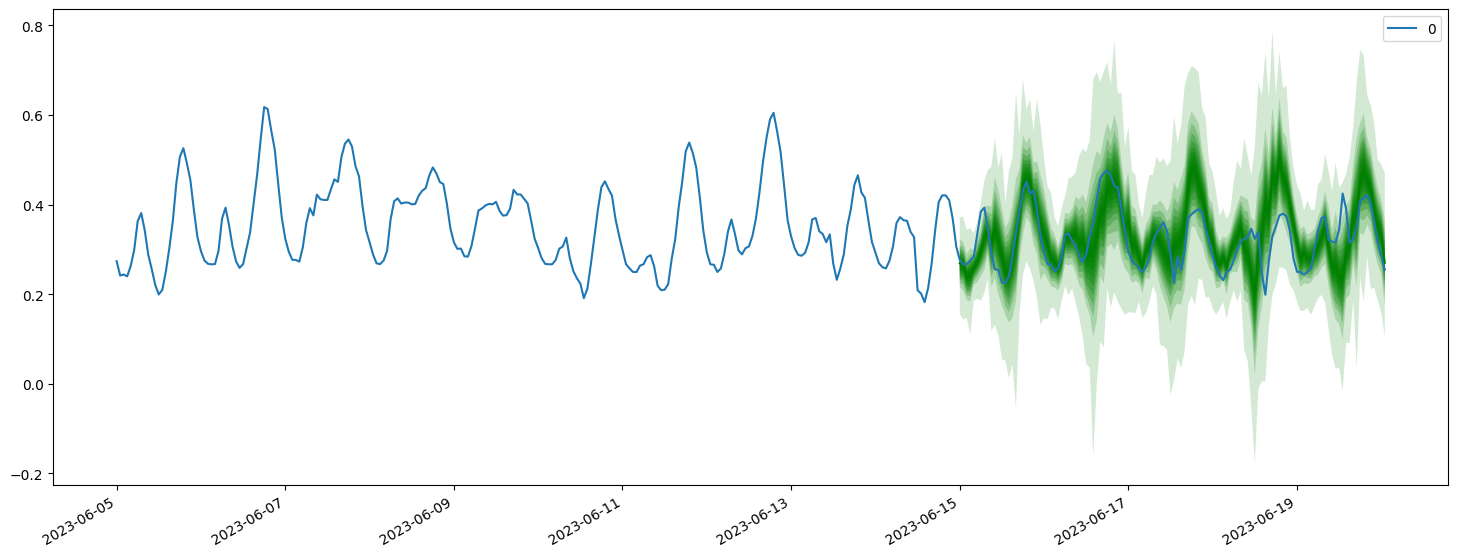

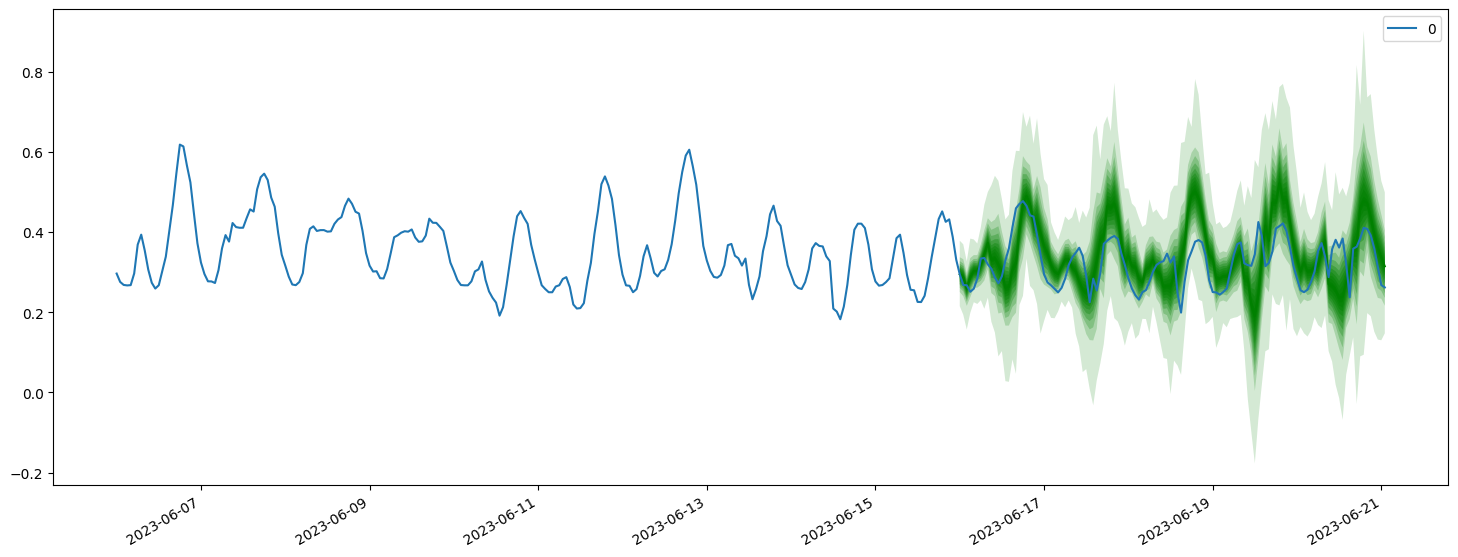

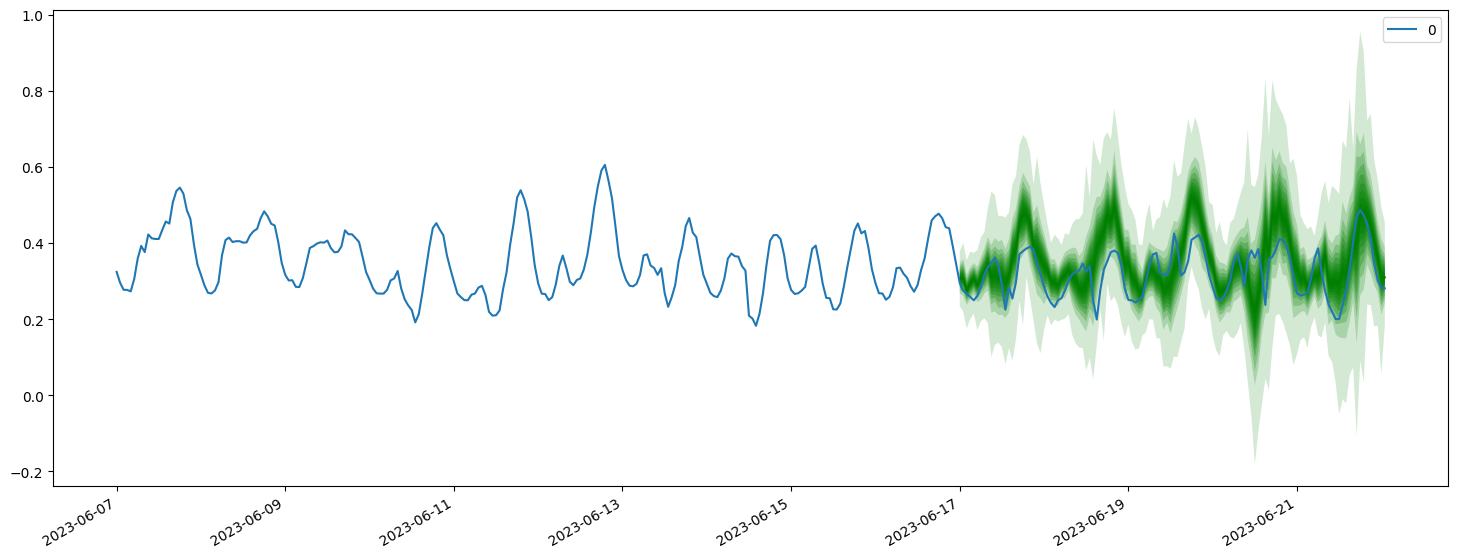

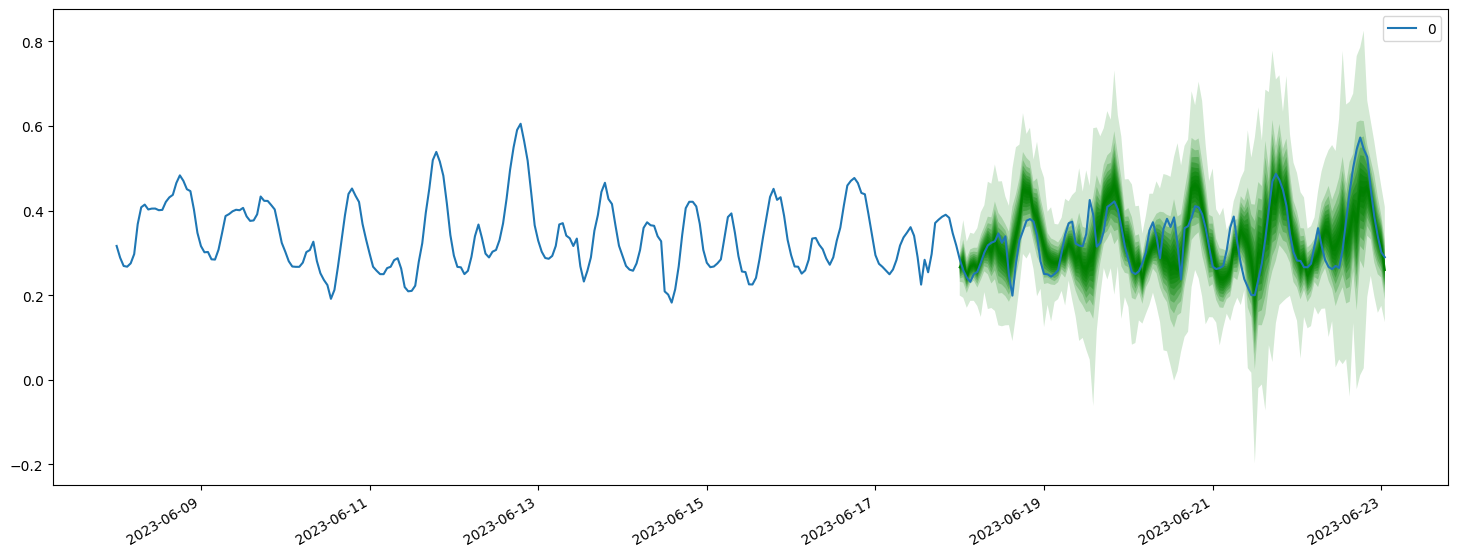

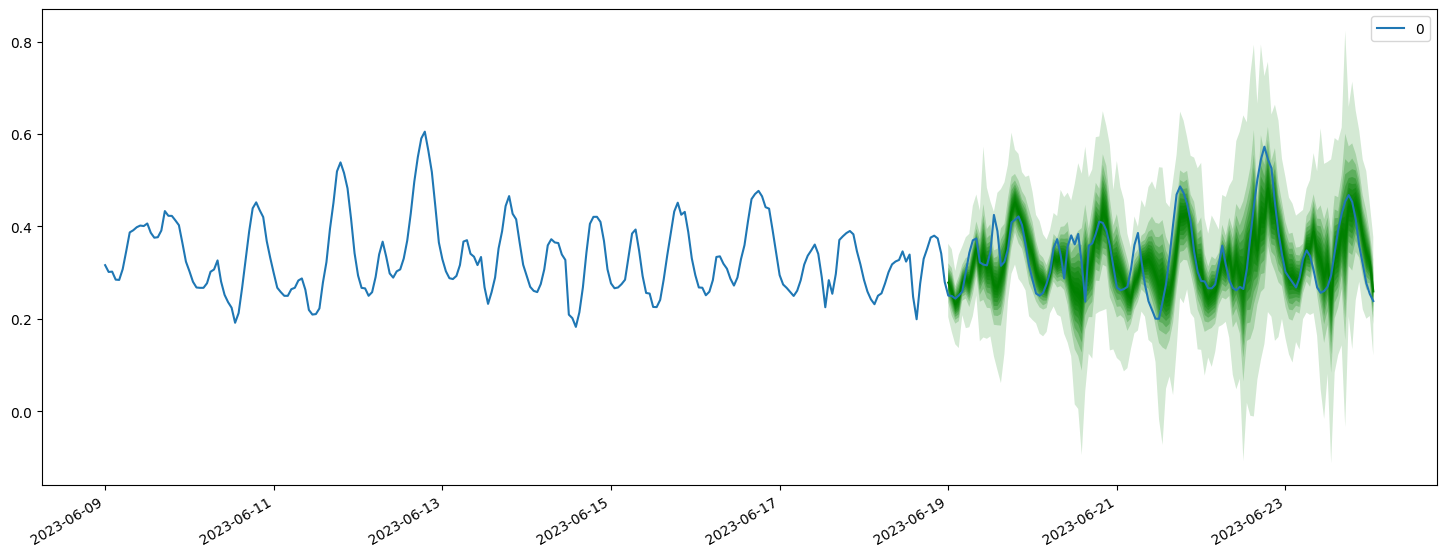

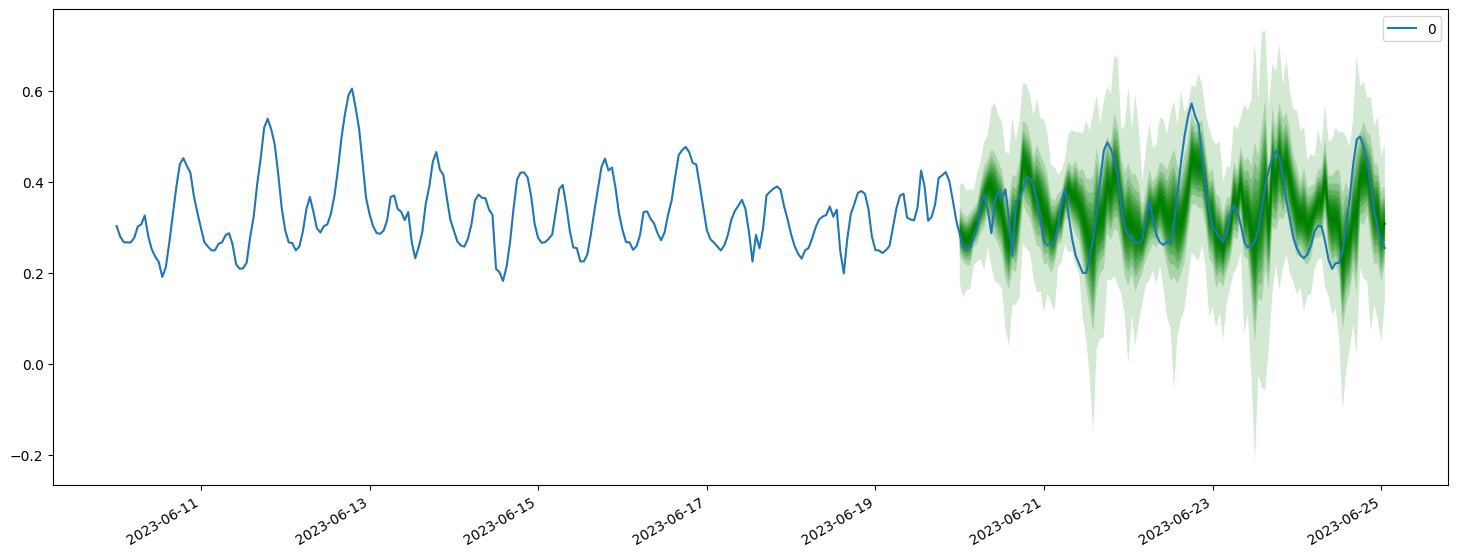

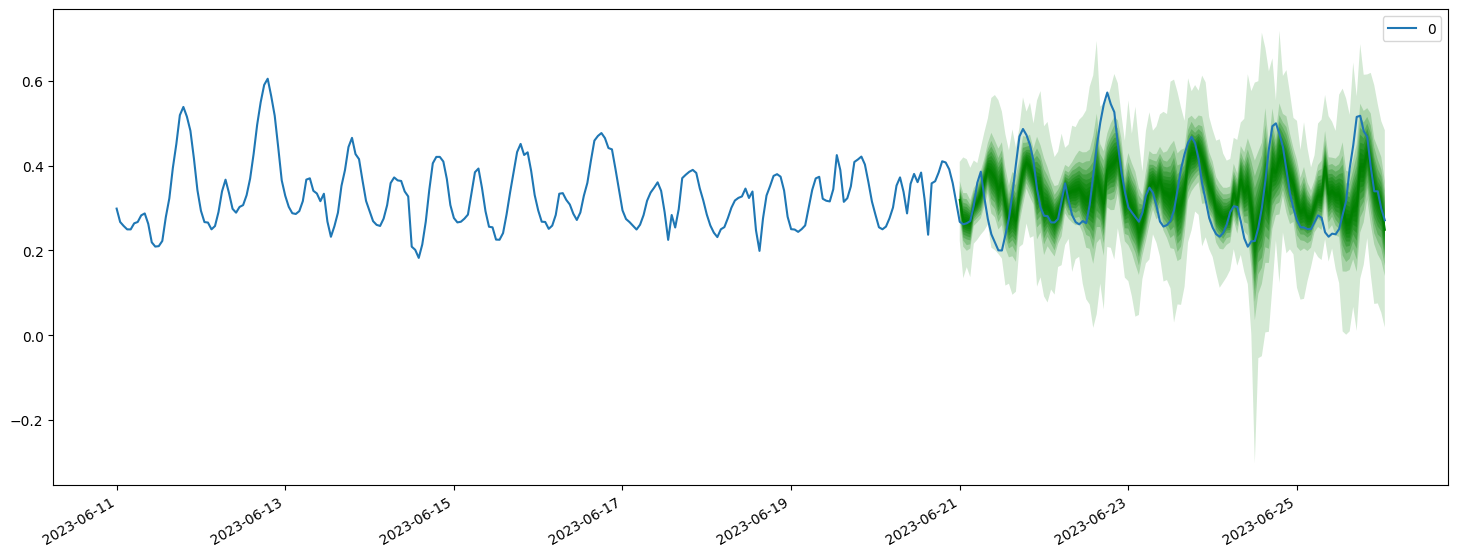

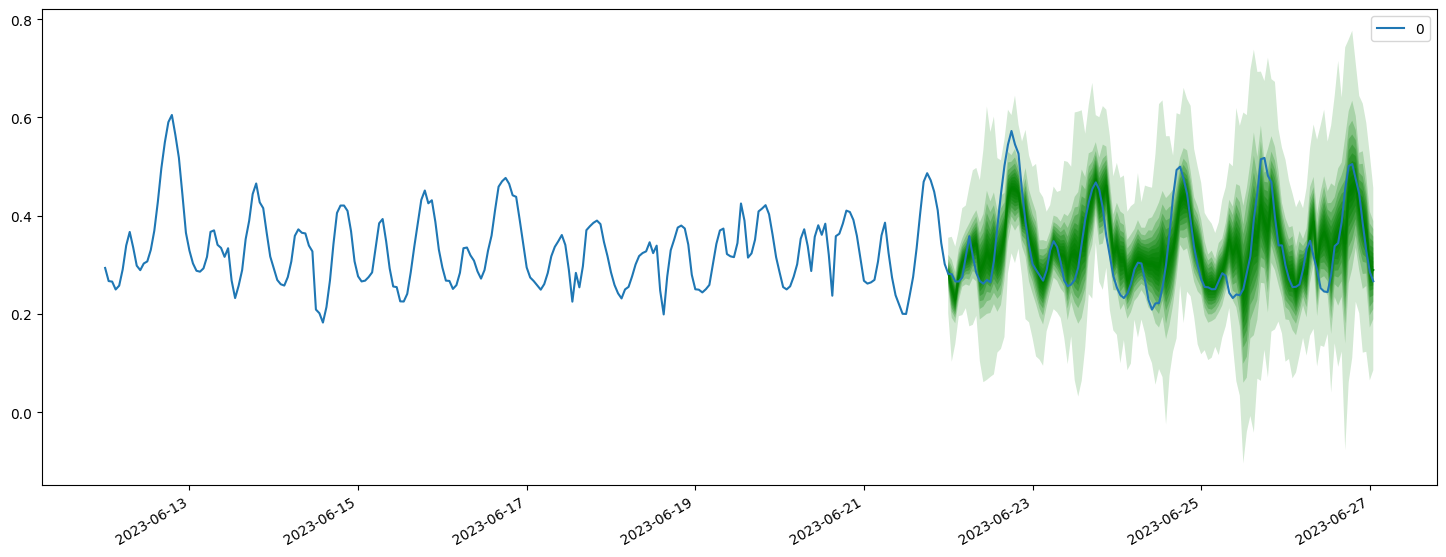

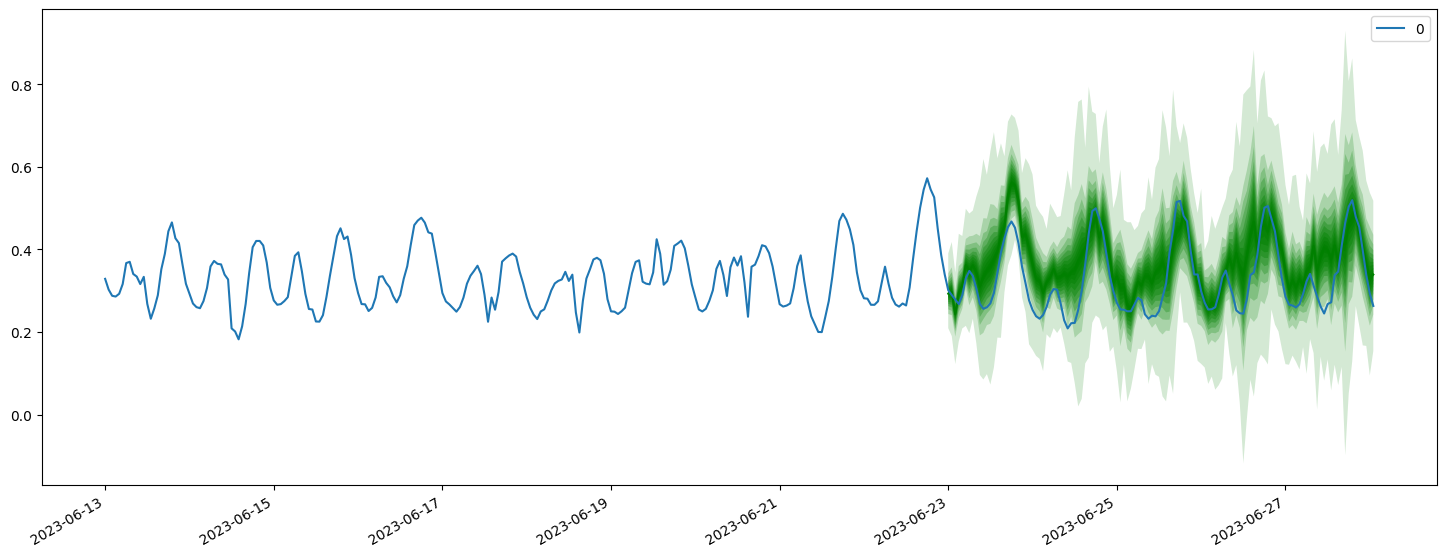

In [ ]:
daily_crps = []
daily_crpss = []
for day in range(13, 24):

  start_date = '2023-06-{:02d}'.format(day - 1 + 5)
  end_date = '2023-06-{:02d}'.format(day + 5)
  preds = np.zeros((24,11))
  vals = []
  forecast_big = predictor_fn(predictor_nn_comp, for_df, "2023-06-{} 00:00:00".format(day), 10, 5)
  for i in range(0, 11):
    # q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
    preds[:,i] = forecast_big[0].quantile(i/10)[-24 - 24 + 1: -24 + 1 ]#- 24 * 8]
    pred2 = preds[:,i] #+ (1 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

    vals.append(pred2)

  obs = for_df[(for_df.timestamp >= start_date + ' 01:00:00') & (for_df.timestamp <= end_date + ' 00:00:00')].value.values
  fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
  crps, crpss, _ = crps_and_crpss_scores(obs, preds, start_date, end_date, 'or')
  print(crps, crpss)
  daily_crps.append(crps)
  daily_crpss.append(crpss)

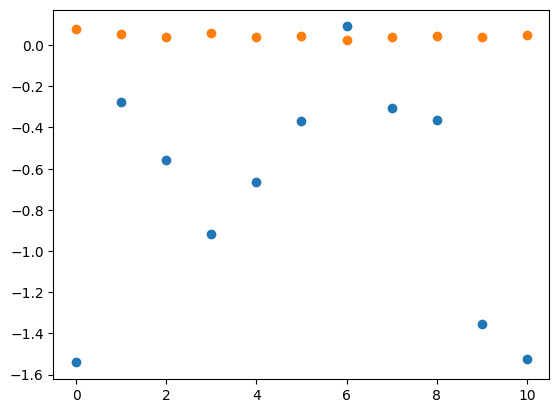

In [ ]:
plt.scatter(range(len(daily_crpss)),daily_crpss)
plt.scatter(range(len(daily_crpss)),daily_crps)

In [ ]:
for_df[(for_df.timestamp >= '2023-06-23' + ' 01:00:00') & (for_df.timestamp <= '2023-06-24' + ' 00:00:00')].value.values

array([0.289677, 0.278757, 0.267764, 0.289048, 0.329725, 0.348112,
       0.335845, 0.305318, 0.268075, 0.256328, 0.26002 , 0.26953 ,
       0.29453 , 0.344252, 0.392683, 0.427372, 0.45433 , 0.467784,
       0.45275 , 0.414939, 0.35813 , 0.318303, 0.277018, 0.253689])

In [ ]:
# forecast_simple = predictor_fn(predictor_nn_sum_2, for_df, "2023-06-26 00:00:00", context_days_nn, prediction_days_nn)


In [ ]:
fx_prob = np.zeros((24,11))
constant_values = np.array([x/10 for x in range(0,11)])
for i in range(11):
    fx_prob[:, i] = constant_values[i]
preds = np.zeros((24,11))
for i in range(11):
    preds[:,i] = forecast_big[0].quantile(i/10)[-24:]#- 24 * 8]

# tf = TimezoneFinder(in_memory=True)
# local_time_zone = tf.timezone_at(lng=or_lon, lat=or_lat)
# or_test_set['timestamp'] = or_test_set['timestamp'].dt.tz_localize(local_time_zone)

In [ ]:
submission2 = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
submission2['timestamp'] = pd.date_range(start = '2023-07-02 01:00:00',
                                         end =  '2023-07-03 00:00:00',
                                         freq='H',
                                         tz = states['or']['local_time_zone']
                                         )
submission2[['p' + str(i*10) for i in range(11)]] = preds

In [ ]:
submission2


,timestamp,p0,p10,p20,p30,p40,p50,p60,p70,p80,p90,p100
0,2023-07-02 01:00:00-07:00,0.406637,0.461086,0.471294,0.477705,0.483506,0.489977,0.495740,0.501409,0.508609,0.518097,0.568148
1,2023-07-02 02:00:00-07:00,0.407791,0.450775,0.461693,0.469121,0.474186,0.480729,0.485292,0.492069,0.500319,0.510273,0.552402
2,2023-07-02 03:00:00-07:00,0.408010,0.446624,0.456698,0.464080,0.469947,0.475020,0.480107,0.486379,0.492405,0.501083,0.550756
3,2023-07-02 04:00:00-07:00,0.411431,0.455034,0.467878,0.474710,0.481042,0.487656,0.493862,0.500321,0.507865,0.519217,0.557490
4,2023-07-02 05:00:00-07:00,0.404667,0.453219,0.466206,0.477285,0.485502,0.493532,0.502559,0.511080,0.520367,0.533662,0.588391
5,2023-07-02 06:00:00-07:00,0.193165,0.305109,0.327028,0.341433,0.355607,0.366156,0.376897,0.390230,0.406773,0.430512,0.524181
6,2023-07-02 07:00:00-07:00,0.025183,0.127407,0.150277,0.163128,0.174763,0.185771,0.196492,0.208259,0.221165,0.243521,0.352440
7,2023-07-02 08:00:00-07:00,-0.265697,-0.126261,-0.090109,-0.068462,-0.048798,-0.030088,-0.013130,0.008413,0.029372,0.059939,0.283465
8,2023-07-02 09:00:00-07:00,-0.354363,-0.216089,-0.191372,-0.166011,-0.146715,-0.126846,-0.110647,-0.094464,-0.068534,-0.037315,0.080289
9,2023-07-02 10:00:00-07:00,-0.381298,-0.230264,-0.181538,-0.151761,-0.132136,-0.109375,-0.086284,-0.068412,-0.040870,-0.005733,0.160383


In [ ]:
upload_function(submission2.set_index('timestamp'),'or')
